In [1]:
# http://gluon.mxnet.io/chapter02_supervised-learning/softmax-regression-gluon.html#Multiclass-logistic-regression-with-gluon

from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np

/usr/local/lib/python3.6/site-packages/mxnet/optimizer.py:136: UserWarning: WARNING: New optimizer mxnet.optimizer.NAG is overriding existing optimizer mxnet.optimizer.NAG
  Optimizer.opt_registry[name].__name__))


In [2]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()
# mnist data

batch_size = 64
num_inputs = 784
num_outputs = 10
num_examples = 60000
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
train_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=True, transform=transform),
                                      batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                              batch_size, shuffle=False)

In [3]:
net = gluon.nn.Dense(num_outputs)
# register param initializer
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

In [4]:
#Loss and Optimizer
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

In [5]:
#Evaluation
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [6]:
evaluate_accuracy(test_data, net)

0.077399999999999997

In [7]:
# Run training loop
epochs = 10
moving_loss = 0.

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()

    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))

Epoch 0. Loss: 2.14464876076, Train_acc 0.791666666667, Test_acc 0.8017
Epoch 1. Loss: 0.914299417814, Train_acc 0.834416666667, Test_acc 0.8461
Epoch 2. Loss: 0.746484454966, Train_acc 0.852866666667, Test_acc 0.862
Epoch 3. Loss: 0.659638033366, Train_acc 0.862333333333, Test_acc 0.8702
Epoch 4. Loss: 0.603901692502, Train_acc 0.870333333333, Test_acc 0.8759
Epoch 5. Loss: 0.563346567603, Train_acc 0.8753, Test_acc 0.8825
Epoch 6. Loss: 0.532394629852, Train_acc 0.87995, Test_acc 0.8841
Epoch 7. Loss: 0.508810897112, Train_acc 0.88405, Test_acc 0.8876
Epoch 8. Loss: 0.487715507046, Train_acc 0.886066666667, Test_acc 0.8897
Epoch 9. Loss: 0.471148131227, Train_acc 0.8903, Test_acc 0.8908


(10, 28, 28, 1)


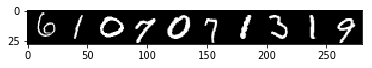

model predictions are: 
[ 6.  1.  0.  7.  0.  7.  1.  3.  1.  9.]
<NDArray 10 @cpu(0)>


In [9]:
# Visualize predictions

import matplotlib.pyplot as plt

def model_predict(net,data):
    output = net(data.as_in_context(model_ctx))
    return nd.argmax(output, axis=1)

# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                              10, shuffle=True)
for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(model_ctx)
    print(data.shape)
    im = nd.transpose(data,(1,0,2,3))
    im = nd.reshape(im,(28,10*28,1))
    imtiles = nd.tile(im, (1,1,3))

    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    break